# Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loader Class Definition

In [15]:
class DataLoader:
    """
    Class to load and inspect a pipe-separated dataset.
    """
    def __init__(self, filepath, sep='|', parse_dates=None):
        """
        filepath: path to the dataset file
        sep: separator (default '|')
        parse_dates: list of columns to parse as dates
        """
        self.filepath = filepath
        self.sep = sep
        self.parse_dates = parse_dates
        self.df = None

    def load_data(self):
        """
        Load the dataset into a pandas DataFrame.
        """
        try:
            self.df = pd.read_csv(self.filepath, sep=self.sep, parse_dates=self.parse_dates, low_memory=False)
            print(f"Data loaded: {self.df.shape[0]} rows × {self.df.shape[1]} columns.")
        except Exception as e:
            print(f"Error loading data: {e}")
        return self.df

    def get_shape(self):
        """Return tuple (n_rows, n_cols) or None if not loaded."""
        if self.df is not None:
            return self.df.shape
        print("Data not loaded yet.")
        return None

    def get_dtypes(self):
        """Return data types of columns or None if not loaded."""
        if self.df is not None:
            return self.df.dtypes
        print("Data not loaded yet.")
        return None

    def head(self, n=5):
        """Return first n rows or None if not loaded."""
        if self.df is not None:
            return self.df.head(n)
        print("Data not loaded yet.")
        return None

    def missing_summary(self):
        """Return missing counts per column sorted descending, or None."""
        if self.df is not None:
            return self.df.isna().sum().sort_values(ascending=False)
        print("Data not loaded yet.")
        return None

    def describe_numeric(self):
        """Return descriptive stats for numeric columns, or None."""
        if self.df is not None:
            return self.df.describe().T
        print("Data not loaded yet.")
        return None


# Data Profiler Class

In [16]:
class DataProfiler:
    """
    Class for profiling loaded DataFrame: univariate, bivariate, outlier detection.
    """
    def __init__(self, df):
        """
        df: pandas DataFrame already loaded by DataLoader
        """
        self.df = df.copy()
        # Pre-calculate LossRatio column if possible
        if 'TotalClaims' in df.columns and 'TotalPremium' in df.columns:
            # Avoid division by zero: set LossRatio to NaN where TotalPremium <= 0
            self.df['LossRatio'] = np.where(self.df['TotalPremium'] > 0,
                                            self.df['TotalClaims'] / self.df['TotalPremium'],
                                            np.nan)
        else:
            print("Warning: 'TotalClaims' or 'TotalPremium' missing; LossRatio not computed.")

    def univariate_numeric(self, col, bins=30, figsize=(6,4)):
        """
        Plot histogram and print summary stats for a numeric column.
        """
        if col not in self.df.columns:
            print(f"Column '{col}' not found.")
            return
        series = self.df[col].dropna()
        # Summary stats
        desc = series.describe()
        skew = series.skew()
        kurt = series.kurtosis()
        print(f"Summary for {col}:\n{desc}\nSkewness: {skew:.3f}, Kurtosis: {kurt:.3f}")
        # Histogram
        plt.figure(figsize=figsize)
        plt.hist(series, bins=bins, edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    def univariate_categorical(self, col, top_n=10, figsize=(6,4)):
        """
        Plot bar chart for top categories in a categorical column.
        """
        if col not in self.df.columns:
            print(f"Column '{col}' not found.")
            return
        counts = self.df[col].value_counts(dropna=False).head(top_n)
        plt.figure(figsize=figsize)
        counts.plot(kind='bar')
        plt.title(f'Top {top_n} categories in {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print(f"Value counts (top {top_n}):\n{counts}")

    def lossratio_by_group(self, group_col, agg_func='mean', min_count=50, figsize=(6,4)):
        """
        Compute and plot LossRatio aggregated by group_col.
        agg_func: 'mean' or 'median'
        min_count: minimum group size to include
        """
        if 'LossRatio' not in self.df.columns:
            print("LossRatio not computed.")
            return
        if group_col not in self.df.columns:
            print(f"Column '{group_col}' not found.")
            return
        grp = self.df.groupby(group_col)['LossRatio'].agg(['mean','median','count'])
        # Filter small groups
        grp = grp[grp['count'] >= min_count]
        if grp.empty:
            print(f"No groups in '{group_col}' with count >= {min_count}.")
            return
        # Choose aggregation
        values = grp[agg_func]
        # Plot
        plt.figure(figsize=figsize)
        values.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'LossRatio {agg_func} by {group_col} (count ≥ {min_count})')
        plt.xlabel(group_col)
        plt.ylabel(f'LossRatio {agg_func}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print(grp.head(10))

    def time_series_lossratio(self, date_col='TransactionMonth', freq='M', figsize=(6,4)):
        """
        Aggregate TotalClaims and TotalPremium by time and plot LossRatio over time.
        date_col: column to use as datetime index
        freq: resample frequency, e.g., 'M' for monthly
        """
        if date_col not in self.df.columns:
            print(f"Column '{date_col}' not found.")
            return
        df_date = self.df.dropna(subset=[date_col, 'TotalPremium', 'TotalClaims'])
        # Ensure datetime
        df_date = df_date.set_index(pd.to_datetime(df_date[date_col]))
        agg = df_date.resample(freq).agg({'TotalClaims':'sum','TotalPremium':'sum'})
        # Compute LossRatio
        agg = agg[agg['TotalPremium'] > 0]
        agg['LossRatio'] = agg['TotalClaims'] / agg['TotalPremium']
        if agg.empty:
            print("No data after filtering for time series.")
            return
        plt.figure(figsize=figsize)
        plt.plot(agg.index, agg['LossRatio'], marker='o')
        plt.title(f'LossRatio over time ({freq})')
        plt.xlabel('Time')
        plt.ylabel('LossRatio')
        plt.tight_layout()
        plt.show()
        print(agg.head())

    def boxplot_outliers(self, col, figsize=(6,4)):
        """
        Box plot for a numeric column to visualize outliers.
        """
        if col not in self.df.columns:
            print(f"Column '{col}' not found.")
            return
        series = self.df[col].dropna()
        plt.figure(figsize=figsize)
        plt.boxplot(series, vert=False)
        plt.title(f'Box plot of {col}')
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()
        # Optionally, show basic outlier thresholds
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        print(f"{col} outlier thresholds: <{lower:.2f} or >{upper:.2f}")

    def sample_extremes(self, col, n=5, largest=True):
        """
        Show top or bottom n records by a numeric column.
        largest=True: show top n; False: bottom n.
        """
        if col not in self.df.columns:
            print(f"Column '{col}' not found.")
            return
        series = self.df[col]
        if largest:
            idx = series.nlargest(n).index
            print(f"Top {n} by {col}:")
        else:
            idx = series.nsmallest(n).index
            print(f"Bottom {n} by {col}:")
        display(self.df.loc[idx])


## Load Data

In [17]:
filepath = '../data/raw/MachineLearningRating_v3.txt'
loader = DataLoader(filepath, sep='|', parse_dates=['TransactionMonth'])
df = loader.load_data()

# Basic inspections
print("Shape:", loader.get_shape())
print("\nColumn dtypes:\n", loader.get_dtypes())
print("\nFirst rows:\n", loader.head(5))
print("\nMissing values (top 10):\n", loader.missing_summary().head(10))
print("\nNumeric summary:\n", loader.describe_numeric().head(10))

Data loaded: 1000098 rows × 52 columns.
Shape: (1000098, 52)

Column dtypes:
 UnderwrittenCoverID                  int64
PolicyID                             int64
TransactionMonth            datetime64[ns]
IsVATRegistered                       bool
Citizenship                         object
LegalType                           object
Title                               object
Language                            object
Bank                                object
AccountType                         object
MaritalStatus                       object
Gender                              object
Country                             object
Province                            object
PostalCode                           int64
MainCrestaZone                      object
SubCrestaZone                       object
ItemType                            object
mmcode                             float64
VehicleType                         object
RegistrationYear                     int64
make               

## Data Profiling

Summary for TotalPremium:
count    1.000098e+06
mean     6.190550e+01
std      2.302845e+02
min     -7.825768e+02
25%      0.000000e+00
50%      2.178333e+00
75%      2.192982e+01
max      6.528260e+04
Name: TotalPremium, dtype: float64
Skewness: 138.596, Kurtosis: 37176.185


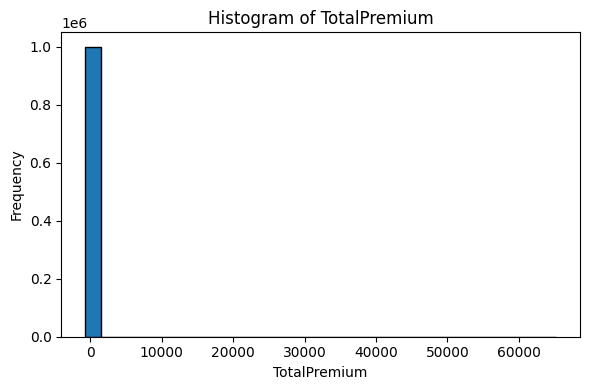

Summary for TotalClaims:
count    1.000098e+06
mean     6.486119e+01
std      2.384075e+03
min     -1.200241e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.930921e+05
Name: TotalClaims, dtype: float64
Skewness: 69.933, Kurtosis: 6791.926


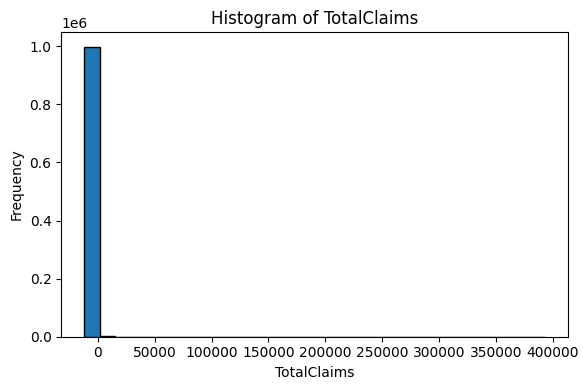

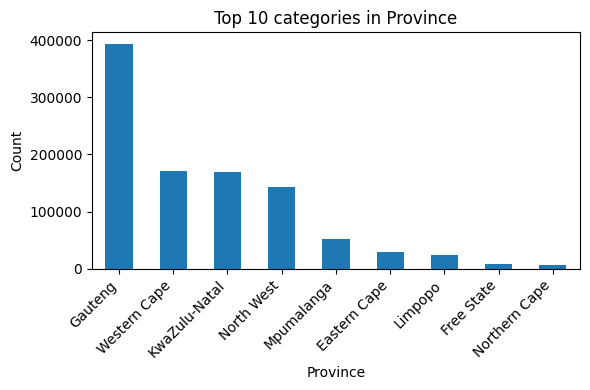

Value counts (top 10):
Province
Gauteng          393865
Western Cape     170796
KwaZulu-Natal    169781
North West       143287
Mpumalanga        52718
Eastern Cape      30336
Limpopo           24836
Free State         8099
Northern Cape      6380
Name: count, dtype: int64


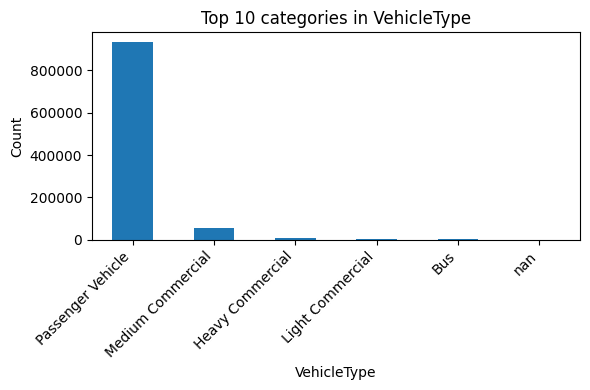

Value counts (top 10):
VehicleType
Passenger Vehicle    933598
Medium Commercial     53985
Heavy Commercial       7401
Light Commercial       3897
Bus                     665
NaN                     552
Name: count, dtype: int64


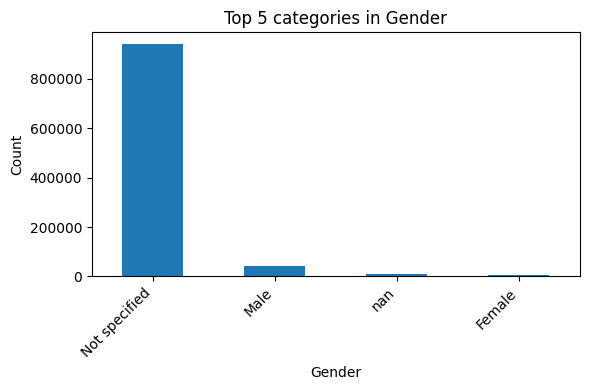

Value counts (top 5):
Gender
Not specified    940990
Male              42817
NaN                9536
Female             6755
Name: count, dtype: int64


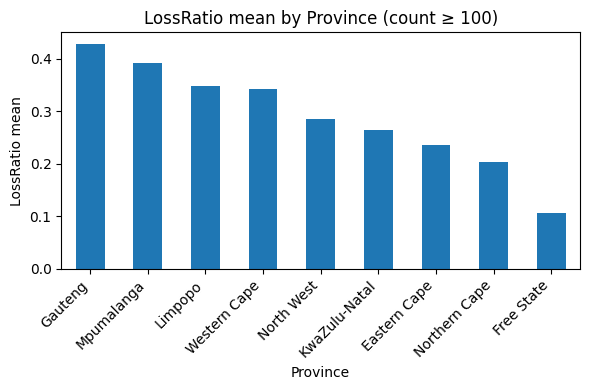

                   mean  median   count
Province                               
Eastern Cape   0.235636     0.0   19694
Free State     0.106209     0.0    5932
Gauteng        0.428927     0.0  240782
KwaZulu-Natal  0.265328     0.0  111896
Limpopo        0.348712     0.0   18009
Mpumalanga     0.392698     0.0   31663
North West     0.285348     0.0   89799
Northern Cape  0.203831     0.0    3643
Western Cape   0.341810     0.0   96758


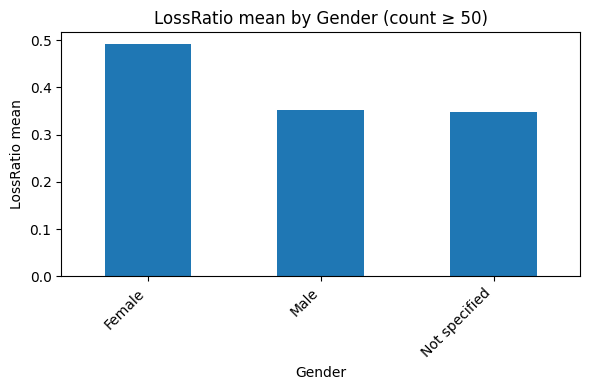

                   mean  median   count
Gender                                 
Female         0.491979     0.0    3404
Male           0.353258     0.0   19083
Not specified  0.347932     0.0  591068


C:\Users\h_user\AppData\Local\Temp\ipykernel_26468\1842065482.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_date.resample(freq).agg({'TotalClaims':'sum','TotalPremium':'sum'})


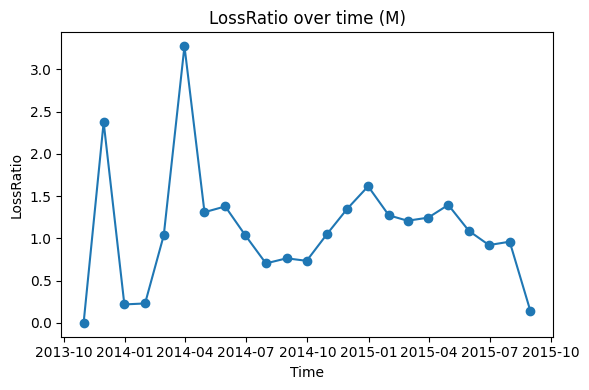

                   TotalClaims  TotalPremium  LossRatio
TransactionMonth                                       
2013-10-31            0.000000    371.063512   0.000000
2013-11-30        50585.078947  21307.467009   2.374054
2013-12-31         9283.385965  42484.748888   0.218511
2014-01-31        12436.859649  54085.196865   0.229949
2014-02-28        62989.307018  60788.436470   1.036205


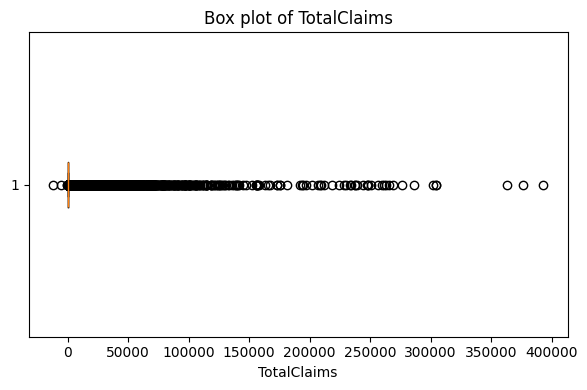

TotalClaims outlier thresholds: <0.00 or >0.00
Top 5 by TotalClaims:


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,LossRatio
451249,72315,4239,2014-12-01,False,,Individual,Mr,English,First National Bank,Savings account,...,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,243.538333,393092.105263,1614.087195
601844,139197,12164,2015-03-01,False,,Individual,Mr,English,Standard Bank,Current account,...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,562.617807,376432.491228,669.073191
818316,124787,10516,2015-05-01,False,,Private company,Mr,English,RMB Private Bank,Current account,...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,1065.027982,363343.421053,341.158568
738349,155659,13767,2015-05-01,False,,Individual,Mrs,English,NaN,NaN,...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,847.567368,304413.394737,359.161296
173451,179198,14512,2015-05-01,False,,Individual,Mr,English,Capitec Bank,Savings account,...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,818.206140,304338.657895,371.958414


In [18]:
if df is not None:
    profiler = DataProfiler(df)
    # Univariate numeric examples
    profiler.univariate_numeric('TotalPremium')
    profiler.univariate_numeric('TotalClaims')
    # Univariate categorical examples
    profiler.univariate_categorical('Province', top_n=10)
    profiler.univariate_categorical('VehicleType', top_n=10)
    profiler.univariate_categorical('Gender', top_n=5)
    # LossRatio by group
    profiler.lossratio_by_group('Province', agg_func='mean', min_count=100)
    profiler.lossratio_by_group('Gender', agg_func='mean', min_count=50)
    # Time series LossRatio
    profiler.time_series_lossratio(date_col='TransactionMonth', freq='M')
    # Outlier detection
    profiler.boxplot_outliers('TotalClaims')
    profiler.sample_extremes('TotalClaims', n=5, largest=True)
else:
    print("DataFrame 'df' is None; ensure DataLoader loaded data successfully.")
